# Tutorial for building fraction impacts as baseline for displacement post-processing

In this code, we apply the concept of displacement following a particular level of building damage post impact calculation. Meaning, we first calculate building fraction damages for each event and store the resulting impact matrices together with the exposure dataframe. On this basis, we can postprocess the results and convert thresholds of buildling-fraction damage to displaced population.

This approach stands in contrast to applying the building threshold prior to the impact calculation on the level of the impact functions.

Here, we explore this approach for the coastal flood hazard in 2 countries (PHL, SOM). We use two vulnerability function sources (CIMA/Capra and IVM). Additionally, we test the feasiblity of applying the same approach to event-based hazards (TC).

In [1]:
# Load country BEM as prep
from climada.util.constants import SYSTEM_DIR
from climada.hazard import TropCyclone, Hazard
from climada.entity.exposures import Exposures
from climada.engine import ImpactCalc
import numpy as np
import os
import copy
from pathlib import Path

#os.chdir('/cluster/project/climate/meilers/scripts/displacement/global-displacement-risk') 
os.chdir('/cluster/project/climate/evelynm/global-displacement-risk') 
import exposure
import vulnerability
import coastal_flood_hazard

# select country here
cntry = 'Somalia'

In [2]:
# load bem
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry, opt='full')
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>1] # filter out rows with basically no population

In [3]:
# assign admin-1
gdf_bem_subcomps = exposure.assign_admin1_attr(gdf_bem_subcomps, exposure.path_admin1_attrs, source='gadm')

In [4]:
# make exposure
exp = Exposures(gdf_bem_subcomps.copy())
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf['value'] = 1 # each building type gets value 1

## FL impacts

### Base Scenario

In [5]:
exp.gdf['impf_FL_cima'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_CIMA)

In [6]:
exp.gdf['impf_FL_ivm'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_IVM)

In [52]:
exp.gdf.head()

,id_1x,iso3,cpx,sector,se_seismo,valhum,valfis,bd_1_floor,bd_2_floor,bd_3_floor,geometry,admin1,longitude,latitude,value,impf_FL,impf_FL_ivm,centr_FL
0,194457751,SOM,3,edu_pub,W2,3.642231,0.011027,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,2,2,125004
1,194457751,SOM,3,edu_pub,W1,1.557365,0.004715,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,2,2,125004
2,194457751,SOM,3,ic_low,W2,15.383508,0.004852,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,2,2,125004
3,194457751,SOM,3,ic_low,W1,6.577763,0.002074,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,2,2,125004
4,194457751,SOM,3,ic_low,RS2,1.697488,0.000535,0.0,0.0,0.0,POINT (43.40417 0.66250),2844.0,43.404167,0.6625,1,3,3,125004


### Flood CIMA

In [8]:
HAZ_FOLDER = Path(f'/cluster/work/climate/evelynm/IDMC_UNU/hazard/flood_HM_CIMA/{cntry}/HISTORICAL/')
HAZ_TYPE = 'FL'

haz_files = np.sort([str(file) for file in HAZ_FOLDER.glob('*.tif')])
rp = np.sort(np.array([int(Path(file).stem[-4:]) for file in haz_files]))

In [9]:
# Create the Hazard object
haz = Hazard.from_raster(
    haz_type=HAZ_TYPE,
    files_intensity=list(haz_files),
    src_crs='WGS84',
    attrs={
        'unit': 'm',
        'event_id': np.arange(len(haz_files)),
        'frequency': 1 / rp
    }
)
haz.intensity = haz.intensity/100

In [ ]:
haz.plot_intensity(event=0)

In [9]:
exp.gdf.rename({'impf_FL_cima' : 'impf_FL'}, axis=1, inplace=True)
imp_cima = ImpactCalc(exp, vulnerability.IMPF_SET_FL_CIMA, haz).impact(save_mat=True)

In [10]:
imp_cima.imp_mat

<9x1439740 sparse matrix of type '<class 'numpy.float64'>'
	with 943524 stored elements in Compressed Sparse Row format>

### Coastal flood

In [5]:
# from scratch:
haz_CF_dir = Path('/cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km')

# get tiles covering the exposure extent
tiles = coastal_flood_hazard.find_tiles(
    exp.gdf['latitude'].min(), exp.gdf['latitude'].max(), exp.gdf['longitude'].min(), exp.gdf['longitude'].max())

# load CF hazard 
CF = coastal_flood_hazard.generate_hazard_object(tiles, haz_CF_dir, 'RCP45', '2020', 'FL')

Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E043/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E044/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E045/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E046/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E047/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E048/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/S02E049/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/h

Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N06E050/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N06E051/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N07E040/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N07E041/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N07E042/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N07E043/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/hazard/coastal_flood/venDEM_scaled_1km/N07E044/RCP45_2020 not found, skipping...
Tile directory /cluster/work/climate/evelynm/IDMC_UNU/h

In [6]:
# Few checks:
print(CF.frequency)
print(CF.event_id)

[1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01
 0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04
 0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.
 0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004
 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02
 0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1
 0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001
 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01
 0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04
 0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.
 0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004
 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02
 0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 0.001 1.    0.1
 0.04  0.02  0.01  0.004 0.001 1.    0.1   0.04  0.02  0.01  0.004 

<GeoAxesSubplot: title={'center': 'FL max intensity at each point'}>

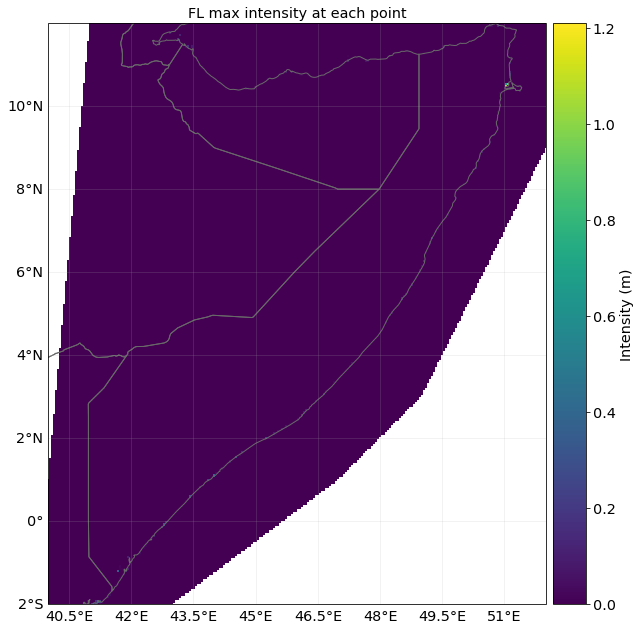

In [9]:
CF.plot_intensity(0)

In [12]:
# other option: load directly from pre-computed hazard files
dir_precomp_haz = Path('/cluster/work/climate/evelynm/IDMC_UNU/hazard/processed/')
CF = Hazard.from_hdf5(dir_precomp_haz+f'{cntry}_CF.hdf5')

In [7]:
# compute damage fractions on buildings; keep "events", i.e. in case of flood RPs individually
# use two impact function sets (2 scenarios)

# scenario 1: capra/cima impfs
exp.gdf['impf_FL'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_CIMA)
impact_bldg_cima = ImpactCalc(exp, vulnerability.IMPF_SET_FL_CIMA, CF).impact(save_mat=True)

2024-05-15 16:49:48,850 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1868 coordinates.


In [8]:
# scenario 2: ivm impfs
exp.gdf['impf_FL'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_FLIMPF_IVM)
impact_bldg_ivm = ImpactCalc(exp, vulnerability.IMPF_SET_FL_IVM, CF).impact(save_mat=True)

2024-05-15 16:49:50,376 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 1868 coordinates.


In [9]:
# set displacement-damage threshold(s) - 3 more scenarios each
dmg_thresh_low = 0.3
dmg_thresh_med = 0.45
dmg_thresh_high = 0.6

In [13]:
# do a few sanity checks
print('max dmg cima:', impact_bldg_cima.imp_mat.data.max(), 'min dmg cima:', impact_bldg_cima.imp_mat.data.min())
print('max dmg ivm:', impact_bldg_ivm.imp_mat.data.max(), 'min dmg ivm:', impact_bldg_ivm.imp_mat.data.min())

max dmg cima: 0.2987988462249438 min dmg cima: 4.7578947685557596e-08
max dmg ivm: 0.9046648263931275 min dmg ivm: 6.4279158323188306e-06


In [10]:
# decide on whether threshold reached for all 2*3 scenarios
displ_low_cima = impact_bldg_cima.imp_mat > dmg_thresh_low
displ_med_cima = impact_bldg_cima.imp_mat > dmg_thresh_med
displ_high_cima = impact_bldg_cima.imp_mat > dmg_thresh_high

displ_low_ivm = impact_bldg_ivm.imp_mat > dmg_thresh_low
displ_med_ivm = impact_bldg_ivm.imp_mat > dmg_thresh_med
displ_high_ivm = impact_bldg_ivm.imp_mat > dmg_thresh_high

In [45]:
# Particular to CF: needs post-processing of many "events" (# of tiles * 7 RPs) into 7 RP "events" 
# --> sum every 7th column (requires blowing up sparse matrix)
# shown here now step by step for one scenario (cima - low) - turned into a function below.

In [11]:
rps = 1/CF.frequency[:7]

In [12]:
displ_full = displ_low_cima.toarray()

In [13]:
# get indices to sum over for each of the 7 RPs(rows)
ix_rps = {}
for ix, rp in enumerate(rps):
    ix_rps[rp] = np.arange(0+ix,displ_full.shape[0],7)

In [14]:
# save impacts to exposure gdf
for rp in rps:
    exp.gdf[f'imp_rp_{rp}'] = displ_full[ix_rps[rp],:].astype(int).sum(axis=0)

In [15]:
exp.gdf.head()

,id_1x,iso3,cpx,sector,se_seismo,valhum,valfis,bd_1_floor,bd_2_floor,bd_3_floor,...,value,impf_FL,centr_FL,imp_rp_1.0,imp_rp_10.0,imp_rp_25.0,imp_rp_50.0,imp_rp_100.0,imp_rp_250.0,imp_rp_1000.0
0,194457751,SOM,3,edu_pub,W2,3.642231,0.011027,0.0,0.0,0.0,...,1,2,125004,0,0,0,0,0,0,0
1,194457751,SOM,3,edu_pub,W1,1.557365,0.004715,0.0,0.0,0.0,...,1,2,125004,0,0,0,0,0,0,0
2,194457751,SOM,3,ic_low,W2,15.383508,0.004852,0.0,0.0,0.0,...,1,2,125004,0,0,0,0,0,0,0
3,194457751,SOM,3,ic_low,W1,6.577763,0.002074,0.0,0.0,0.0,...,1,2,125004,0,0,0,0,0,0,0
4,194457751,SOM,3,ic_low,RS2,1.697488,0.000535,0.0,0.0,0.0,...,1,3,125004,0,0,0,0,0,0,0


In [16]:
# groupe exposure gdf by admin1 and sum over impacts (keep only these)
imps_admin1 = exp.gdf.groupby('admin1').sum()[[f'imp_rp_{rp}' for rp in rps]]

In [17]:
# from this we can now manually compute the AED
imps_admin1['aed'] = 0
for rp in rps:
    imps_admin1['aed']+= imps_admin1[f'imp_rp_{rp}']/rp 

In [18]:
imps_admin1

,imp_rp_1.0,imp_rp_10.0,imp_rp_25.0,imp_rp_50.0,imp_rp_100.0,imp_rp_250.0,imp_rp_1000.0,aed
admin1,,,,,,,,
925.0,0,0,0,0,0,0,0,0.0
1500.0,0,0,0,0,0,0,0,0.0
2836.0,0,0,0,0,0,0,0,0.0
2837.0,0,0,0,0,0,0,0,0.0
2838.0,0,0,0,0,0,0,0,0.0
2839.0,0,0,0,0,0,0,0,0.0
2840.0,0,0,0,0,0,0,0,0.0
2841.0,0,0,0,0,0,0,0,0.0
2842.0,0,0,0,0,0,0,0,0.0


In [19]:
def agg_sparse_rps(sparse_bool, exp_gdf, rps, scen_name, group_admin1=True):
    """
    Aggregate a sparse boolean impact matrix (displacement True/False) obtained from various tiles and RP maps
    into the full exposure format per RP.
    
    Parameters
    -----------
    sparse_bool: sparse.csr_matrix
        imp_mat with types bool (contrasted against dmg threshold)
    rps : np.array 
        unique return periods to group by (1/frequ of hazard events)
    exp_gdf : gpd.GeoDataFrame
        exposure geodataframe to append impacts to
    scen_name : str 
        scenario name to differentiate various impact matrices by(suggestion {impfsource}_{thresh})
    group_admin1 : bool
        whether to group results by admin1 (default: True), else full exp_gdf returned
        
    Returns
    -------
    DataFrame with columns imp_{rps}_{scen_name}, either full exposure or grouped by admin1
    """
    full_bool = sparse_bool.toarray()
    
    # get indices to sum over for each of the 7 RPs(rows)
    ix_rps = {}
    for ix, rp in enumerate(rps):
        ix_rps[rp] = np.arange(0+ix,full_bool.shape[0],7)
    
    # save impacts to exposure gdf
    for rp in rps:
        exp_gdf[f'imp_rp_{rp}_{scen_name}'] = full_bool[ix_rps[rp],:].astype(int).sum(axis=0)
    
    # groupe exposure gdf by admin1 and sum over impacts (keep only these)
    if group_admin1:
        return exp_gdf.groupby('admin1').sum()[[f'imp_rp_{rp}_{scen_name}' for rp in rps]]
    
    return exp_gdf[[f'imp_rp_{rp}_{scen_name}' for rp in rps]]

In [20]:
def compute_aeds(df_imps, rps, scen_name):
    """
    Manually compute average anually expected displacement, as 
    sum(displacement(rpx)/(rpx)) forall rpx
    
    Parameters
    ----------
    df_imps, 
    rps, 
    scen_name
    
    
    Returns
    --------
    df_imps with additional column aed
    """
    df_imps[f'aed_{scen_name}'] = 0
    for rp in rps:
        df_imps[f'aed_{scen_name}']+= df_imps[f'imp_rp_{rp}_{scen_name}']/rp 
    return df_imps

In [54]:
# show for a few examples:

In [21]:
imp_cima_low = agg_sparse_rps(displ_low_cima, exp.gdf, rps, 'cima_low', group_admin1=True)
imp_cima_low = compute_aeds(imp_cima_low, rps, 'cima_low')
imp_cima_low

,imp_rp_1.0_cima_low,imp_rp_10.0_cima_low,imp_rp_25.0_cima_low,imp_rp_50.0_cima_low,imp_rp_100.0_cima_low,imp_rp_250.0_cima_low,imp_rp_1000.0_cima_low,aed_cima_low
admin1,,,,,,,,
925.0,0,0,0,0,0,0,0,0.0
1500.0,0,0,0,0,0,0,0,0.0
2836.0,0,0,0,0,0,0,0,0.0
2837.0,0,0,0,0,0,0,0,0.0
2838.0,0,0,0,0,0,0,0,0.0
2839.0,0,0,0,0,0,0,0,0.0
2840.0,0,0,0,0,0,0,0,0.0
2841.0,0,0,0,0,0,0,0,0.0
2842.0,0,0,0,0,0,0,0,0.0


In [22]:
imp_ivm_low = agg_sparse_rps(displ_low_ivm, exp.gdf, rps, 'ivm_low', group_admin1=True)
imp_ivm_low = compute_aeds(imp_ivm_low, rps, 'ivm_low')
imp_ivm_low

,imp_rp_1.0_ivm_low,imp_rp_10.0_ivm_low,imp_rp_25.0_ivm_low,imp_rp_50.0_ivm_low,imp_rp_100.0_ivm_low,imp_rp_250.0_ivm_low,imp_rp_1000.0_ivm_low,aed_ivm_low
admin1,,,,,,,,
925.0,0,0,0,0,0,0,0,0.000
1500.0,0,0,0,0,0,0,0,0.000
2836.0,0,0,0,0,0,0,0,0.000
2837.0,0,0,0,0,0,0,0,0.000
2838.0,25,25,25,25,25,51,51,29.505
2839.0,0,0,0,0,0,0,0,0.000
2840.0,0,0,0,0,0,0,0,0.000
2841.0,0,0,0,0,0,0,0,0.000
2842.0,0,0,0,0,0,0,0,0.000


In [28]:
imp_ivm_high = agg_sparse_rps(displ_high_ivm, exp.gdf, rps, 'ivm_high', group_admin1=True)
imp_ivm_high = compute_aeds(imp_ivm_high, rps, 'ivm_high')
imp_ivm_high

,imp_rp_1.0_ivm_high,imp_rp_10.0_ivm_high,imp_rp_25.0_ivm_high,imp_rp_50.0_ivm_high,imp_rp_100.0_ivm_high,imp_rp_250.0_ivm_high,imp_rp_1000.0_ivm_high,aed_ivm_high
admin1,,,,,,,,
925.0,0,0,0,0,0,0,0,0.000
1500.0,0,0,0,0,0,0,0,0.000
2836.0,0,0,0,0,0,0,0,0.000
2837.0,0,0,0,0,0,0,0,0.000
2838.0,0,0,0,0,0,0,0,0.000
2839.0,0,0,0,0,0,0,0,0.000
2840.0,0,0,0,0,0,0,0,0.000
2841.0,0,0,0,0,0,0,0,0.000
2842.0,0,0,0,0,0,0,0,0.000


In [24]:
# compute for all remaining ones (make dicts out of all these):
imp_cima_med = agg_sparse_rps(displ_med_cima, exp.gdf, rps, 'cima_med', group_admin1=True)
imp_cima_med = compute_aeds(imp_cima_med, rps, 'cima_med')

imp_cima_high = agg_sparse_rps(displ_high_cima, exp.gdf, rps, 'cima_high', group_admin1=True)
imp_cima_high = compute_aeds(imp_cima_high, rps, 'cima_high')

imp_ivm_med = agg_sparse_rps(displ_med_ivm, exp.gdf, rps, 'ivm_med', group_admin1=True)
imp_ivm_med = compute_aeds(imp_ivm_med, rps, 'ivm_med')

In [ ]:
# group all scenarios and get median, min, max

In [35]:
import pandas as pd
imp_all_scens = pd.concat([imp_cima_low, imp_cima_med, imp_cima_high, imp_ivm_low, imp_ivm_med, imp_ivm_high], axis=1
                         )
imp_all_scens

,imp_rp_1.0_cima_low,imp_rp_10.0_cima_low,imp_rp_25.0_cima_low,imp_rp_50.0_cima_low,imp_rp_100.0_cima_low,imp_rp_250.0_cima_low,imp_rp_1000.0_cima_low,aed_cima_low,imp_rp_1.0_cima_med,imp_rp_10.0_cima_med,...,imp_rp_1000.0_ivm_med,aed_ivm_med,imp_rp_1.0_ivm_high,imp_rp_10.0_ivm_high,imp_rp_25.0_ivm_high,imp_rp_50.0_ivm_high,imp_rp_100.0_ivm_high,imp_rp_250.0_ivm_high,imp_rp_1000.0_ivm_high,aed_ivm_high
admin1,,,,,,,,,,,,,,,,,,,,,
925.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
1500.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2836.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2837.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2838.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2839.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2840.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2841.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000
2842.0,0,0,0,0,0,0,0,0.0,0,0,...,0,0.000,0,0,0,0,0,0,0,0.000


In [44]:
imp_stats = pd.DataFrame()

for rp in rps:
    imp_stats[f'rp_{rp}_min'] = np.min(imp_all_scens[[col for col in imp_all_scens.columns if str(rp) in col ]], axis=1)
    imp_stats[f'rp_{rp}_med'] = np.median(imp_all_scens[[col for col in imp_all_scens.columns if str(rp) in col ]], axis=1)
    imp_stats[f'rp_{rp}_max'] = np.min(imp_all_scens[[col for col in imp_all_scens.columns if str(rp) in col ]], axis=1)
imp_stats[f'aed_min'] = np.min(imp_all_scens[[col for col in imp_all_scens.columns if 'aed' in col ]], axis=1)
imp_stats[f'aed_med'] = np.median(imp_all_scens[[col for col in imp_all_scens.columns if 'aed' in col ]], axis=1)
imp_stats[f'aed_max'] = np.max(imp_all_scens[[col for col in imp_all_scens.columns if 'aed' in col ]], axis=1)
imp_stats

,rp_1.0_min,rp_1.0_med,rp_1.0_max,rp_10.0_min,rp_10.0_med,rp_10.0_max,rp_25.0_min,rp_25.0_med,rp_25.0_max,rp_50.0_min,...,rp_100.0_max,rp_250.0_min,rp_250.0_med,rp_250.0_max,rp_1000.0_min,rp_1000.0_med,rp_1000.0_max,aed_min,aed_med,aed_max
admin1,,,,,,,,,,,,,,,,,,,,,
925.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
1500.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2836.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2837.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2838.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,29.505
2839.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2840.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2841.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000
2842.0,0,0.0,0,0,0.0,0,0,0.0,0,0,...,0,0,0.0,0,0,0.0,0,0.0,0.0000,0.000


In [ ]:
# Question: what to save? 

# sparse imp_mats (bldg frac dmg) for further postprocessing 
# all-scenarios-admin1-df
# stats-df
# write country-aed to dict 

In [ ]:
# TODO next: write one pipeline that accepts only iso3 code (for running in batches on cluster)

## TC impact functions

### Base scenario

In [ ]:
exp.gdf['impf_TC_base'] = exp.gdf['se_seismo'].map(vulnerability.DICT_PAGER_TCIMPF_HAZUS)

### Min, med, max scenarios

In [ ]:
# we modify the dictionary to point to the "_min", "_med" and "_max" vulnerability functions everywhere 
DICT_TCIMPF_MIN = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'min']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}
DICT_TCIMPF_MED = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'med']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}
DICT_TCIMPF_MAX = {key: vulnerability.DICT_HAZUS_IMPF_TC_HAZUS[value[:-3]+'max']
                           for key, value in vulnerability.DICT_PAGER2HAZUS.items()}

In [ ]:
exp.gdf['impf_TC_min'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MIN) 

In [ ]:
exp.gdf['impf_TC_med'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MED) 

In [ ]:
exp.gdf['impf_TC_max'] = exp.gdf['se_seismo'].map(DICT_TCIMPF_MAX) 

### Perform impact calcs and compare

In [ ]:
# load TC hazard phl
if cntry == 'Somalia':
    reg = 'IO'
elif cntry == 'Philippines':
    reg = 'WP'
else:
    reg = print('no country-basin assingment found')

haz_TC_dir = Path('/cluster/work/climate/meilers/climada/data/hazard/present')
haz_TC = TropCyclone.from_hdf5(haz_TC_dir.joinpath(f'TC_{reg}_0150as_MIT_H08.hdf5'))

In [ ]:
TC = haz_TC.select(extent=(
    exp.gdf['longitude'].min(), exp.gdf['longitude'].max(), exp.gdf['latitude'].min(), exp.gdf['latitude'].max()))

In [ ]:
exp.gdf.rename({'impf_TC_base' : 'impf_TC'}, axis=1, inplace=True)

imp_base = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [ ]:
exp.gdf.rename({'impf_TC' : 'impf_TC_base'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_TC_min' : 'impf_TC'}, axis=1, inplace=True)

imp_min = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [ ]:
exp.gdf.rename({'impf_TC' : 'impf_TC_min'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_TC_med' : 'impf_TC'}, axis=1, inplace=True)

imp_med = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [ ]:
exp.gdf.rename({'impf_TC' : 'impf_TC_med'}, axis=1, inplace=True) # change column name back
exp.gdf.rename({'impf_TC_max' : 'impf_TC'}, axis=1, inplace=True)

imp_max = ImpactCalc(exp, vulnerability.IMPF_SET_TC_HAZUS, TC).impact()

In [ ]:
print(imp_base.aai_agg, imp_min.aai_agg, imp_med.aai_agg, imp_max.aai_agg)